In [1]:
import pystac_client
import time

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

In [3]:
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds

In [4]:
import numpy    
# função retirada da galeria do github Brasil Data Cube

def normalize(array):                                                    
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [5]:
token = 'r5p7J7kpqIbnPY47jX4i8YfaVcKq7iPFsO3nQQ6OpF'    #Change to your token

In [6]:
satelite = 'S2-16D-2'  #Satellite selection

In [7]:
# function taken from Brazil Data Cube's GitHub code gallery

def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Read raster window as numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)

    # Expects the bounding box has 4 values
    w, s, e, n = bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        return dataset.read(1, window=window, masked=masked)
    


In [8]:
parameters = dict(access_token=token)
service_STAC = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/stac/', parameters=parameters)

In [9]:
service_STAC.get_collection(satelite).get_items() 

<generator object CollectionClient.get_items at 0x7fa43f624200>

In [10]:
bbox=(-52.6490,-23.1770,-52.5977,-23.1449)

item_search = service_STAC.search(bbox=bbox,
                             datetime='2020-01-01/2022-12-31',
                             collections=[satelite])

total_dataset=item_search.matched() #numero de ficheiros de informação disponiveis com estas defenições
total_dataset = total_dataset-1
#bbox = dimensoes do quadrado de pesquisa a obter em conjunto com o mapa do BDC
#datetime = linha temporal pertendida a obter os ficheiros de informação
#collections= satelite que ira fornecer a informação

In [11]:
counter = 0
for item in item_search.get_items():    #listagem de ficheiros de informação disponiveis 
    print(f"[{counter}].  {item}")
    counter += 1

[0].  <Item id=S2-16D_V2_023030_20220930>
[1].  <Item id=S2-16D_V2_023030_20220914>
[2].  <Item id=S2-16D_V2_023030_20220829>
[3].  <Item id=S2-16D_V2_023030_20220813>
[4].  <Item id=S2-16D_V2_023030_20220728>
[5].  <Item id=S2-16D_V2_023030_20220712>
[6].  <Item id=S2-16D_V2_023030_20220626>
[7].  <Item id=S2-16D_V2_023030_20220610>
[8].  <Item id=S2-16D_V2_023030_20220525>
[9].  <Item id=S2-16D_V2_023030_20220509>
[10].  <Item id=S2-16D_V2_023030_20220423>
[11].  <Item id=S2-16D_V2_023030_20220407>
[12].  <Item id=S2-16D_V2_023030_20220322>
[13].  <Item id=S2-16D_V2_023030_20220306>
[14].  <Item id=S2-16D_V2_023030_20220218>
[15].  <Item id=S2-16D_V2_023030_20220202>
[16].  <Item id=S2-16D_V2_023030_20220117>
[17].  <Item id=S2-16D_V2_023030_20220101>
[18].  <Item id=S2-16D_V2_023030_20211219>
[19].  <Item id=S2-16D_V2_023030_20211203>
[20].  <Item id=S2-16D_V2_023030_20211117>
[21].  <Item id=S2-16D_V2_023030_20211101>
[22].  <Item id=S2-16D_V2_023030_20211016>
[23].  <Item id=S2-16

In [12]:
items = list(item_search.get_items()) #Listagem dos items num array com o nome items


for counter in range(18):
    item_current = items[counter]  # Supondo que você queria usar items[counter] ao invés de items[1]
    
    red = read(item_current.assets['B04'].href, bbox=bbox)         
    nir = read(item_current.assets['B08'].href, bbox=bbox)
    ndvi = (nir - red) / (nir + red)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))  # Plot em gray e jet
    ax1.imshow(ndvi, cmap='gray')
    ax2.imshow(ndvi, cmap='jet')
    
    plt.show()
    time.sleep(5)

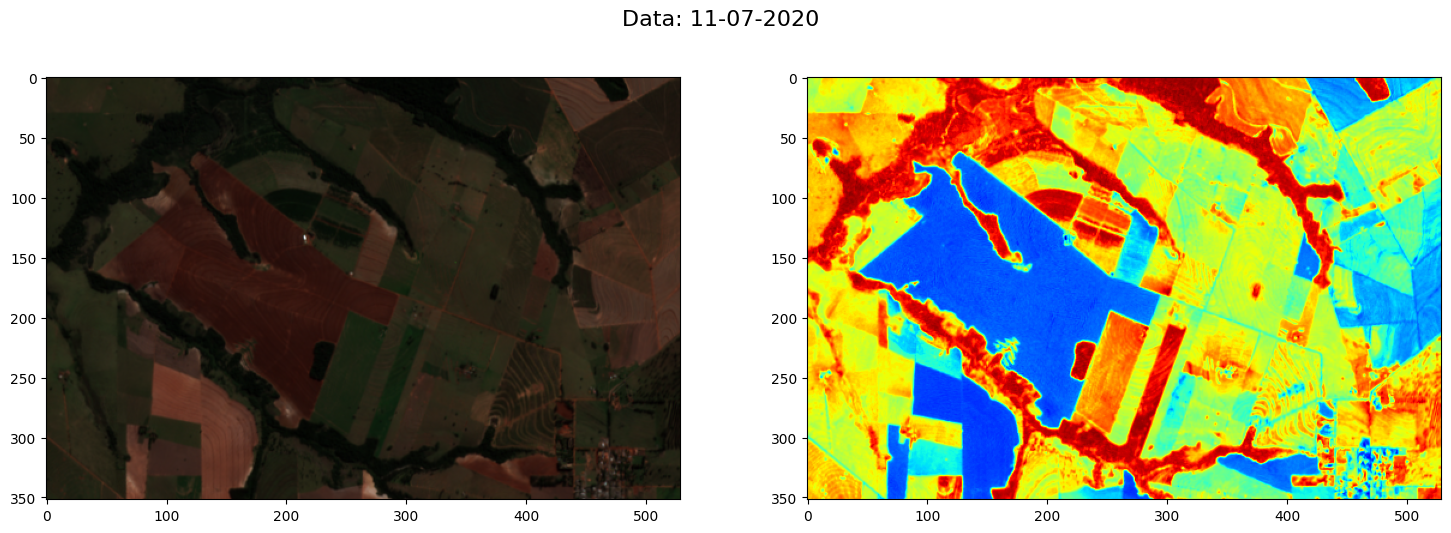

In [ ]:
for counter in range(total_dataset, -1, -1):
    item_current = items[counter]  # Pega o item atual
    
    item_id = item_current.id
    item_date = item_id[-8:]  # Extrai os últimos 8 caracteres do ID
    formatted_date = f"{item_date[6:]}-{item_date[4:6]}-{item_date[:4]}"  # Formata como dd-mm-yyyy
    
    green = read(item_current.assets['B03'].href, bbox=bbox)             #Para visualizar algum Conteudo de um destes arrays basta,
    blue = read(item_current.assets['B02'].href, bbox=bbox)   
    red = read(item_current.assets['B04'].href, bbox=bbox)         
    nir = read(item_current.assets['B08'].href, bbox=bbox)
    ndvi = (nir - red) / (nir + red)
    rgb = numpy.dstack((normalize(red), normalize(green), normalize(blue)))   #Plot da Imagen RGB
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))  # Cria os subplots
    ax1.imshow(rgb)
    ax2.imshow(ndvi, cmap='jet')
    
    fig.suptitle(f"Data: {formatted_date}", fontsize=16, y=0.65)
  
    clear_output(wait=True)  # Limpa a saída anterior
    display(fig)  # Exibe a nova figura
    
    plt.close(fig)  # Fecha a figura para liberar memória-{item_date[6:]